In [3]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [4]:
from img_utils import data_to_DF
path = "../nybolig-scrape/output"
houses_df = data_to_DF(path, max_houses=1000)

2024-02-20 13:36:04.682839: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[ WARN:0@17.283] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@22.153] global loadsave.cpp:244 findDecoder imread_(''): can't open/read file: check file path/integrity


In [5]:
from utils import remove_outliers
from img_utils import preprocess_images

#Take only Copenhagen, and Ejerlejligheder
houses_df = houses_df[(houses_df['postal_code'] >= 1000) & (houses_df['postal_code'] <= 2920)]
houses_df = houses_df[houses_df['type'] == 'ejerlejlighed']

#Remove theoutliers 
houses_df = remove_outliers(houses_df, 'price')

#Drop houses with no floorplan
houses_df = houses_df.dropna(subset=['image_floorplan'])

In [6]:
import numpy as np
import pandas as pd
#Set the basement_size to 0 if it is NaN
houses_df['basement_size'] = houses_df['basement_size'].fillna(0)

#Set the year_rebuilt to year_built if it is NaN
houses_df['year_rebuilt'] = houses_df['year_rebuilt'].fillna(houses_df['year_built'])


#Encode the features: postal_code, type, energy_class
houses_df['postal_code'] = houses_df['postal_code'].astype('category').cat.codes
houses_df['type'] = houses_df['type'].astype('category').cat.codes
houses_df['energy_label'] = houses_df['energy_label'].astype('category').cat.codes

#Drop Adress
houses_df = houses_df.drop(columns=['address'])

In [7]:
from sklearn.model_selection import train_test_split

#DROP ANY NAN VALUES
houses_df = houses_df.dropna()

# Split the data into train, validation and test sets with a 60-20-20 ratio
train_df, test_df = train_test_split(houses_df, test_size=0.2, random_state=0)
train_df, valid_df = train_test_split(train_df, test_size=0.20, random_state=0)

# Feeding Vision Prediction into Random Forrest

In [9]:
import joblib
from tensorflow.keras.models import load_model
loadModel = True
if loadModel:
  mobilenet_model = load_model('Trained_models/MobileNet_Continous.keras')

2/2 [==============================] - 2s 605ms/step
postal_code 0.1454
type 0.0
size 0.6914
basement_size 0.0
rooms 0.0118
year_built 0.0357
year_rebuilt 0.0329
energy_label 0.0329
mobilenet_prediction 0.0497
Mean Squared Error: 1004484120623.6364
Mean Absolute Error: 647716.9090909091
R^2: 0.740176915266467


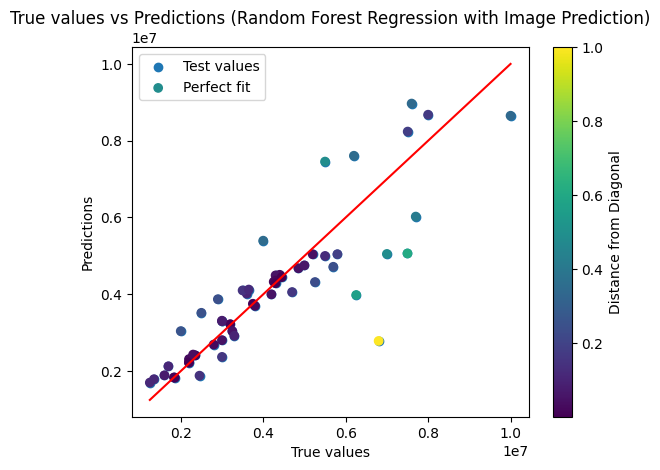

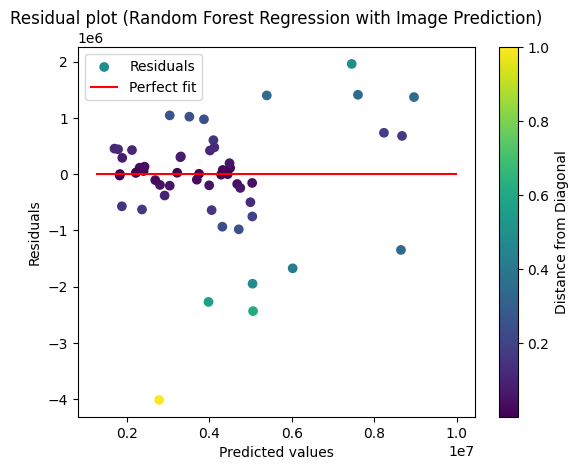

In [10]:

from sklearn.ensemble import RandomForestRegressor
from utils import plot_regression_results, regression_stats
def RF_with_vision_pred(vision_model, train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold):
    #Add vision predictions to the dataframes
    train_df['mobilenet_prediction'] = vision_model.predict(preprocess_images(train_df,'image_floorplan',   target_width, target_height, resize, gray_scale, threshhold))
    valid_df['mobilenet_prediction'] = vision_model.predict(preprocess_images(valid_df,'image_floorplan',   target_width, target_height, resize, gray_scale, threshhold))
    test_df['mobilenet_prediction'] = vision_model.predict(preprocess_images(test_df,'image_floorplan',   target_width, target_height, resize, gray_scale, threshhold))

    #Setup Training Data
    x_train = train_df.drop(columns=['image_floorplan', 'price'])
    y_train = train_df['price']
    x_valid = valid_df.drop(columns=['image_floorpl an', 'price'])
    y_valid = valid_df['price']
    x_test = test_df.drop(columns=['image_floorplan', 'price'])
    y_test = test_df['price']

    #Fit eht model 
    forest = RandomForestRegressor(random_state=0)
    forest.fit(x_train, y_train)

    #Get the estimators
    for feature, importance in zip(x_train.columns, forest.feature_importances_):
        print((feature), round(importance,4))

    
    y_test_pred = forest.predict(x_test)

    #plot the results
    regression_stats(y_test, y_test_pred)
    plot_regression_results('Random Forest Regression with Image Prediction', y_test,  y_test_pred)
    return None 

target_width = 224
target_height = 224
resize = True
gray_scale = False
threshhold = True
scale = False

RF_with_vision_pred(mobilenet_model, train_df, valid_df, test_df, target_width, target_height, resize, gray_scale, threshhold)